In [1]:
import torch

print(torch.__version__)
print(torch.version.cuda)

1.7.1
10.2


### Testing trained model

Load a small sample of testing images for inference.

In [46]:
from model import Classifier
from torchvision import transforms, datasets, utils
from torch.utils.data import DataLoader
from torch import nn

import matplotlib.pyplot as plt

device = 'cuda'
batch = 4

labels = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'neutral',
    5: 'sad',
    6: 'surprise'
}

def prepare_dataset(root_dir, batch_size, transform):
    test_dataset = datasets.ImageFolder(root=f'{root_dir}/inference/', transform=transform)
    test_dataloader = DataLoader(test_dataset, batch_size, shuffle=True, num_workers=4)
    return test_dataloader

def test(test_dataloader, model, loss_fn):
    size = len(test_dataloader.dataset)
    test_batches = len(test_dataloader)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for x, y in test_dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            for i,j,im in zip(pred.argmax(1), y, x):
                print(f"Predicted: {labels[i.item()]} Actual: {labels[j.item()]}")


    test_loss /= test_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# prepare dataset
transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor()
])

test_dataloader = prepare_dataset('./dataset', 4, transform)
    
model = Classifier().to(device)

checkpoint = torch.load('./checkpoints/model_epoch_49.pth')
model.load_state_dict(checkpoint)


# define loss objective
loss_fn = nn.CrossEntropyLoss()

test(test_dataloader, model, loss_fn)



Predicted: happy Actual: happy
Predicted: angry Actual: angry
Predicted: fear Actual: fear
Predicted: sad Actual: angry
Predicted: sad Actual: angry
Predicted: fear Actual: neutral
Predicted: fear Actual: disgust
Predicted: happy Actual: happy
Predicted: fear Actual: fear
Predicted: sad Actual: neutral
Predicted: surprise Actual: surprise
Predicted: sad Actual: sad
Predicted: surprise Actual: surprise
Predicted: surprise Actual: surprise
Predicted: fear Actual: fear
Predicted: happy Actual: angry
Predicted: neutral Actual: disgust
Predicted: neutral Actual: neutral
Predicted: surprise Actual: surprise
Predicted: angry Actual: disgust
Predicted: angry Actual: sad
Predicted: sad Actual: sad
Predicted: happy Actual: happy
Predicted: fear Actual: fear
Predicted: happy Actual: happy
Predicted: neutral Actual: neutral
Predicted: surprise Actual: disgust
Predicted: sad Actual: sad
Test Error: 
 Accuracy: 64.3%, Avg loss: 2.180708 



### Custom input images

Load custom images in mini-batch of 1 to perform classification using our trained model. You can place your custom images in input_images folder.

In [56]:
# preprocess custom images to gray scale 48x48
import cv2

path = './input_images'
out_path = './processed_input/images'

images = [cv2.resize(cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2GRAY),(48,48)) for file in glob.glob(f'{path}/*.jpg')]

i = 0
for im in images:
    cv2.imwrite(f"{out_path}/image_{i}.jpg", im)
    i+=1


2


predictions: ['happy', 'happy']


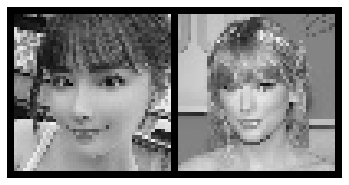

In [57]:
import cv2
import matplotlib.pyplot as plt
import glob

from torchvision import transforms, datasets, utils
from torch.utils.data import DataLoader
from model import Classifier

batch = 1
path = './processed_input'

def prepare_dataset(root_dir, batch_size, transform):
    test_dataset = datasets.ImageFolder(root=f'{root_dir}/', transform=transform)
    test_dataloader = DataLoader(test_dataset, batch_size, shuffle=True, num_workers=4)
    return test_dataloader

def test(test_dataloader, model):
    model.eval()
    prediction = []

    with torch.no_grad():
        for x, y in test_dataloader:
            x = x.to(device)
            pred = model(x)
            prediction.append(labels[pred.argmax(1).item()])

    return prediction


# prepare dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

test_dataloader = prepare_dataset(f'./{path}', batch, transform)

model = Classifier().to(device)

checkpoint = torch.load('./checkpoints/model_epoch_49.pth')
model.load_state_dict(checkpoint)

# im = cv2.imread('./input_images/images/input.jpg')
images = [transform(cv2.imread(file)) for file in glob.glob(f'{path}/images/*.jpg')]
grid = utils.make_grid(images, nrow=len(images))
plt.axis('off')
plt.imshow(grid.permute(1, 2, 0))

prediction = test(test_dataloader, model)

print(f'predictions: {prediction}')
